# **Retail Sales Analytics with PySpark**

# Setup in Google Colab

In [1]:
# Install PySpark
!pip install pyspark

# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Retail-Capstone").getOrCreate()
sc = spark.sparkContext

# Prepare Data

In [2]:
# Customers Data
customers_data = [
    (1, "Rahul Sharma", "Bangalore", 28),
    (2, "Priya Singh", "Delhi", 32),
    (3, "Aman Kumar", "Hyderabad", 25),
    (4, "Sneha Reddy", "Chennai", 35),
    (5, "Arjun Mehta", "Mumbai", 30),
    (6, "Divya Nair", "Delhi", 29)
]
customers_cols = ["customer_id", "name", "city", "age"]
customers_df = spark.createDataFrame(customers_data, customers_cols)

# Products Data
products_data = [
    (101, "Laptop", "Electronics", 55000),
    (102, "Mobile", "Electronics", 25000),
    (103, "Headphones", "Electronics", 3000),
    (104, "Chair", "Furniture", 5000),
    (105, "Book", "Stationery", 700),
    (106, "Shoes", "Fashion", 2500)
]
products_cols = ["product_id", "product_name", "category", "price"]
products_df = spark.createDataFrame(products_data, products_cols)

# Orders Data
orders_data = [
    (1001, 1, 101, 1, "2024-01-10"),
    (1002, 2, 102, 2, "2024-01-12"),
    (1003, 1, 103, 3, "2024-02-05"),
    (1004, 3, 104, 1, "2024-02-08"),
    (1005, 5, 105, 5, "2024-03-01"),
    (1006, 6, 106, 2, "2024-03-15"),
    (1007, 7, 101, 1, "2024-03-20")  # Invalid customer
]
orders_cols = ["order_id", "customer_id", "product_id", "quantity", "order_date"]
orders_df = spark.createDataFrame(orders_data, orders_cols)


# Capstone Tasks

**Part A – RDD Basics**
1. Convert a list of numbers [10, 20, 30, 40, 50] into an RDD.
Find sum, max, min, and average using RDD transformations & actions.
2. Create an RDD of sentences and perform word count.

In [3]:
nums_rdd = sc.parallelize([10, 20, 30, 40, 50])
print("Sum:", nums_rdd.sum())
print("Max:", nums_rdd.max())
print("Min:", nums_rdd.min())
print("Avg:", nums_rdd.mean())

Sum: 150
Max: 50
Min: 10
Avg: 30.0


In [4]:
sentences = sc.parallelize(["PySpark is fun", "Data engineering with Spark", "Big data and Spark"])
words = sentences.flatMap(lambda line: line.split(" "))
word_counts = words.map(lambda word: (word.lower(), 1)).reduceByKey(lambda a, b: a + b)
word_counts.collect()

[('fun', 1),
 ('engineering', 1),
 ('with', 1),
 ('big', 1),
 ('and', 1),
 ('pyspark', 1),
 ('is', 1),
 ('data', 2),
 ('spark', 2)]

**Part B – DataFrame Operations**

3. Show all customer names and their cities.
4. Find customers older than 30.
5. List all distinct product categories.
6. Find top 3 most expensive products.

In [5]:
customers_df.select("name", "city").show()

+------------+---------+
|        name|     city|
+------------+---------+
|Rahul Sharma|Bangalore|
| Priya Singh|    Delhi|
|  Aman Kumar|Hyderabad|
| Sneha Reddy|  Chennai|
| Arjun Mehta|   Mumbai|
|  Divya Nair|    Delhi|
+------------+---------+



In [6]:
customers_df.filter(customers_df.age > 30).show()

+-----------+-----------+-------+---+
|customer_id|       name|   city|age|
+-----------+-----------+-------+---+
|          2|Priya Singh|  Delhi| 32|
|          4|Sneha Reddy|Chennai| 35|
+-----------+-----------+-------+---+



In [7]:
products_df.select("category").distinct().show()

+-----------+
|   category|
+-----------+
|Electronics|
| Stationery|
|    Fashion|
|  Furniture|
+-----------+



In [8]:
products_df.orderBy("price", ascending=False).limit(3).show()

+----------+------------+-----------+-----+
|product_id|product_name|   category|price|
+----------+------------+-----------+-----+
|       101|      Laptop|Electronics|55000|
|       102|      Mobile|Electronics|25000|
|       104|       Chair|  Furniture| 5000|
+----------+------------+-----------+-----+



**Part C – Aggregations**

7. Find the average age of customers per city.
8. Calculate total revenue generated from each product.
9. Find the most popular product (by total quantity sold).

In [9]:
customers_df.groupBy("city").avg("age").withColumnRenamed("avg(age)", "avg_age").show()

+---------+-------+
|     city|avg_age|
+---------+-------+
|Bangalore|   28.0|
|    Delhi|   30.5|
|Hyderabad|   25.0|
|  Chennai|   35.0|
|   Mumbai|   30.0|
+---------+-------+



In [10]:
from pyspark.sql.functions import col

orders_with_price = orders_df.join(products_df, "product_id")
revenue_df = orders_with_price.withColumn("revenue", col("quantity") * col("price"))
revenue_df.groupBy("product_id", "product_name").sum("revenue").withColumnRenamed("sum(revenue)", "total_revenue").show()

+----------+------------+-------------+
|product_id|product_name|total_revenue|
+----------+------------+-------------+
|       101|      Laptop|       110000|
|       102|      Mobile|        50000|
|       103|  Headphones|         9000|
|       104|       Chair|         5000|
|       105|        Book|         3500|
|       106|       Shoes|         5000|
+----------+------------+-------------+



In [11]:
orders_df.groupBy("product_id").sum("quantity") \
    .orderBy("sum(quantity)", ascending=False).limit(1).show()

+----------+-------------+
|product_id|sum(quantity)|
+----------+-------------+
|       105|            5|
+----------+-------------+



**Part D – Joins**

10. Join customers with orders to list each customer’s purchases.
11. Join orders with products to get order details (product name + category).
12. Find customers who never placed an order.
13. Find products that were never ordered.

In [12]:
customers_df.join(orders_df, "customer_id", "inner").show()

+-----------+------------+---------+---+--------+----------+--------+----------+
|customer_id|        name|     city|age|order_id|product_id|quantity|order_date|
+-----------+------------+---------+---+--------+----------+--------+----------+
|          1|Rahul Sharma|Bangalore| 28|    1001|       101|       1|2024-01-10|
|          1|Rahul Sharma|Bangalore| 28|    1003|       103|       3|2024-02-05|
|          2| Priya Singh|    Delhi| 32|    1002|       102|       2|2024-01-12|
|          3|  Aman Kumar|Hyderabad| 25|    1004|       104|       1|2024-02-08|
|          5| Arjun Mehta|   Mumbai| 30|    1005|       105|       5|2024-03-01|
|          6|  Divya Nair|    Delhi| 29|    1006|       106|       2|2024-03-15|
+-----------+------------+---------+---+--------+----------+--------+----------+



In [13]:
orders_df.join(products_df, "product_id", "inner").select("order_id", "product_name", "category", "quantity").show()

+--------+------------+-----------+--------+
|order_id|product_name|   category|quantity|
+--------+------------+-----------+--------+
|    1001|      Laptop|Electronics|       1|
|    1007|      Laptop|Electronics|       1|
|    1002|      Mobile|Electronics|       2|
|    1003|  Headphones|Electronics|       3|
|    1004|       Chair|  Furniture|       1|
|    1005|        Book| Stationery|       5|
|    1006|       Shoes|    Fashion|       2|
+--------+------------+-----------+--------+



In [14]:
customers_df.join(orders_df, "customer_id", "left_anti").show()

+-----------+-----------+-------+---+
|customer_id|       name|   city|age|
+-----------+-----------+-------+---+
|          4|Sneha Reddy|Chennai| 35|
+-----------+-----------+-------+---+



In [15]:
products_df.join(orders_df, "product_id", "left_anti").show()

+----------+------------+--------+-----+
|product_id|product_name|category|price|
+----------+------------+--------+-----+
+----------+------------+--------+-----+



**Part E – SQL Queries**

14. Register all DataFrames ( customers , products , orders ) as temp views.
15. Query: Find the top 2 cities by total revenue.
16. Query: Find customers who spent more than
50,000 in total.
17. Query: Find the best-selling product category by revenue.

In [16]:
customers_df.createOrReplaceTempView("customers")
products_df.createOrReplaceTempView("products")
orders_df.createOrReplaceTempView("orders")

In [17]:
spark.sql("""
SELECT c.city, SUM(p.price * o.quantity) as total_revenue
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN products p ON o.product_id = p.product_id
GROUP BY c.city
ORDER BY total_revenue DESC
LIMIT 2
""").show()

+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|Bangalore|        64000|
|    Delhi|        55000|
+---------+-------------+



In [18]:
spark.sql("""
SELECT c.name, SUM(p.price * o.quantity) as total_spent
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN products p ON o.product_id = p.product_id
GROUP BY c.name
HAVING total_spent > 50000
""").show()

+------------+-----------+
|        name|total_spent|
+------------+-----------+
|Rahul Sharma|      64000|
+------------+-----------+



In [19]:
spark.sql("""
SELECT p.category, SUM(p.price * o.quantity) as total_revenue
FROM orders o
JOIN products p ON o.product_id = p.product_id
GROUP BY p.category
ORDER BY total_revenue DESC
LIMIT 1
""").show()

+-----------+-------------+
|   category|total_revenue|
+-----------+-------------+
|Electronics|       169000|
+-----------+-------------+



**Part F – File I/O**

18. Save the orders_df DataFrame into CSV format.
19. Load it back into a new DataFrame.
20. Save the products_df DataFrame into JSON format and reload it.

In [20]:
orders_df.write.csv("orders_csv", header=True, mode="overwrite")

In [21]:
orders_loaded = spark.read.csv("orders_csv", header=True, inferSchema=True)
orders_loaded.show()

+--------+-----------+----------+--------+----------+
|order_id|customer_id|product_id|quantity|order_date|
+--------+-----------+----------+--------+----------+
|    1004|          3|       104|       1|2024-02-08|
|    1005|          5|       105|       5|2024-03-01|
|    1006|          6|       106|       2|2024-03-15|
|    1007|          7|       101|       1|2024-03-20|
|    1001|          1|       101|       1|2024-01-10|
|    1002|          2|       102|       2|2024-01-12|
|    1003|          1|       103|       3|2024-02-05|
+--------+-----------+----------+--------+----------+



In [22]:
products_df.write.json("products_json", mode="overwrite")
products_loaded = spark.read.json("products_json")
products_loaded.show()

+-----------+-----+----------+------------+
|   category|price|product_id|product_name|
+-----------+-----+----------+------------+
|Electronics|55000|       101|      Laptop|
|Electronics|25000|       102|      Mobile|
|Electronics| 3000|       103|  Headphones|
|  Furniture| 5000|       104|       Chair|
| Stationery|  700|       105|        Book|
|    Fashion| 2500|       106|       Shoes|
+-----------+-----+----------+------------+



**Part G – Visualization (in Colab)**

21. Convert PySpark DataFrame → Pandas ( toPandas() ).
22. Plot Revenue by Category as a bar chart.
23. Plot Number of Orders per Month as a line chart.
24. Plot Revenue vs Quantity as a scatter plot.

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

orders_pd = orders_df.toPandas()
products_pd = products_df.toPandas()
customers_pd = customers_df.toPandas()

# Join for full order info
orders_full = orders_with_price.toPandas()

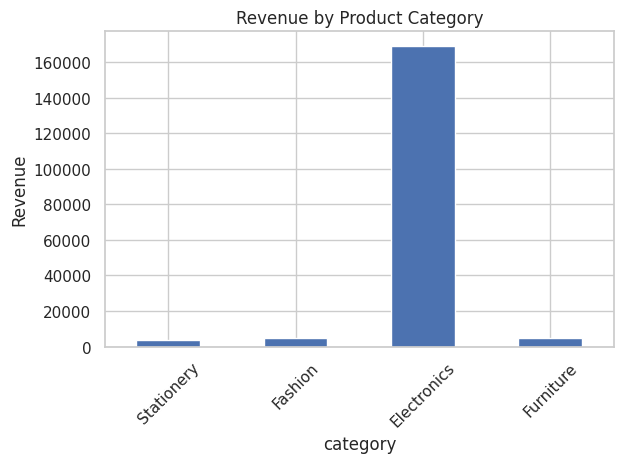

In [25]:
rev_cat = orders_with_price.withColumn("revenue", col("price") * col("quantity")) \
    .groupBy("category").sum("revenue").toPandas()

rev_cat.plot(kind="bar", x="category", y="sum(revenue)", legend=False)
plt.ylabel("Revenue")
plt.title("Revenue by Product Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

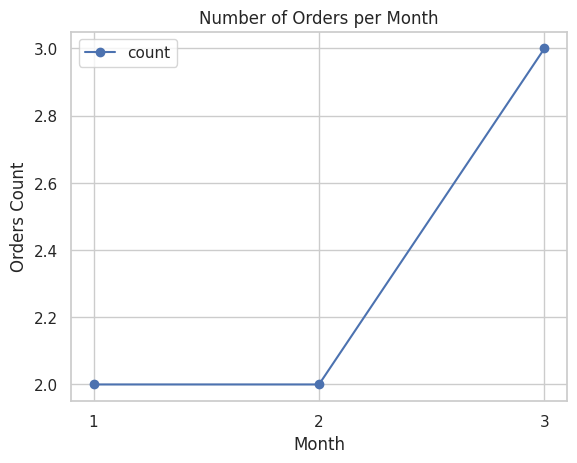

In [26]:
from pyspark.sql.functions import month, to_date

orders_month = orders_df.withColumn("month", month(to_date("order_date", "yyyy-MM-dd"))) \
    .groupBy("month").count().orderBy("month").toPandas()

orders_month.plot(x="month", y="count", kind="line", marker='o')
plt.title("Number of Orders per Month")
plt.xlabel("Month")
plt.ylabel("Orders Count")
plt.grid(True)
plt.xticks(orders_month["month"])
plt.show()

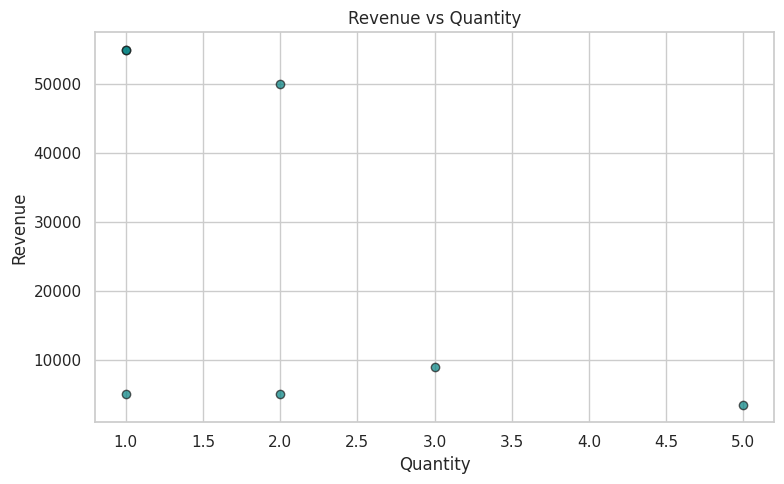

In [31]:
# Calculate revenue in the Pandas DataFrame
orders_full['revenue'] = orders_full['price'] * orders_full['quantity']

plt.figure(figsize=(8,5))
plt.scatter(orders_full["quantity"], orders_full["revenue"], alpha=0.7, color="teal", edgecolors="k")
plt.title("Revenue vs Quantity")
plt.xlabel("Quantity")
plt.ylabel("Revenue")
plt.grid(True)
plt.tight_layout()
plt.show()